In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from deem import deem
from matplotlib.markers import MarkerStyle
import matplotlib.patches as mpatches

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("openmic_classmap_10.json", "r") as f: # only consider 10 classes of Openmic dataset
    openmic_class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
with open("class_align.json", "r") as f: 
    class_align = json.load(f)

with open("genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

In [7]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

## performance drop

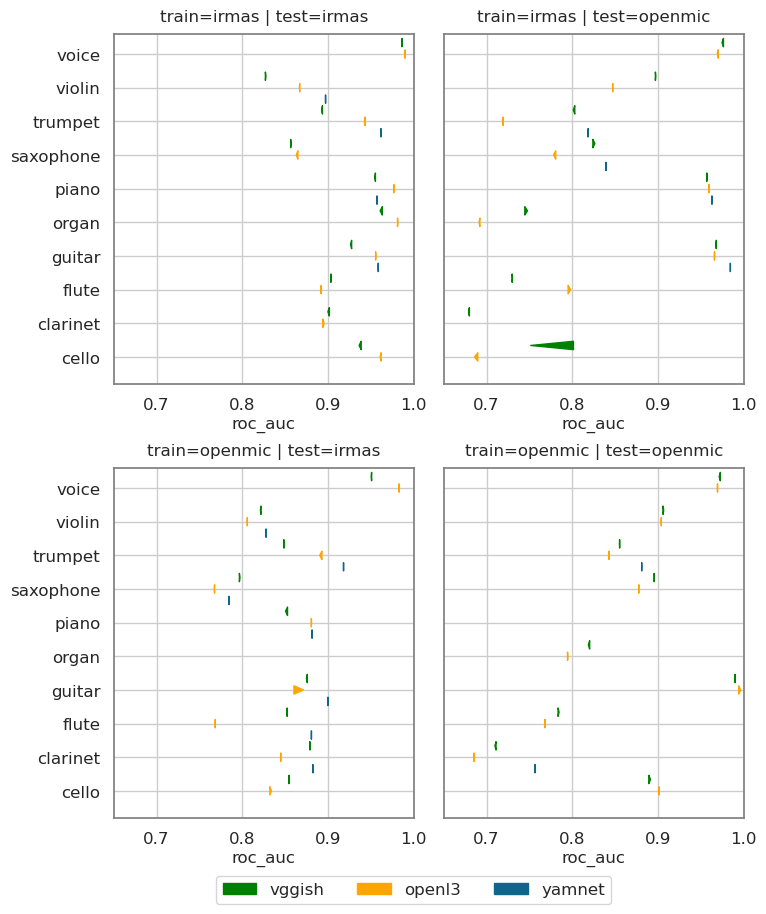

In [8]:
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 20 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(instrument_map)) * 5 + 1.7,
                   'openl3': np.arange(len(instrument_map)) * 5,
                   'yamnet': np.arange(len(instrument_map)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-mlda']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = list(df[df['embedding']==bias_lir_nonlir[1]][metric])
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

#         y = y - dist
#         x = list(df[df['embedding']==bias_lir_nonlir[2]][metric])
# #         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
#         for mark in range(len(y)):
#             ax.annotate('', (x[mark], y[mark]), 
#                     xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
#                         arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title('train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_linear_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(6,7))

size = 12
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'openmic'; test_set = 'irmas'
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48])

# Creating legend with color box
patch1 = mpatches.Patch(color='green', label='vggish')
patch2 = mpatches.Patch(color='orange', label='openl3')
patch3 = mpatches.Patch(color='#0e668b', label='yamnet')
plt.legend(handles=[patch1, patch2, patch3], loc="lower center", ncol=3, bbox_to_anchor=(1, -0.27))
plt.grid(True)

train_set = 'openmic'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'irmas'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48]); 
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
# plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/irmas_openmic_lda.pdf', bbox_inches = "tight")

## original performance

In [9]:
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['test_set']==test_set]
    df = df_visual1[df_visual1['train_set']==train_set]

    dist = .3
    y = np.arange(len(instrument_map)) * 5 + 1.5

    color = 'green'; embedding = 'vggish'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 
    color = 'orange'; embedding = 'openl3'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 - 1.5
    color = '#0e668b'; embedding = 'yamnet'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')

In [10]:
result_all = pd.read_csv('results/result_linear_all.csv')
result_all['debias_method'] = [list(result_all['embedding'])[k].replace(list(result_all['embedding'])[k].split('-')[0], '') \
                               for k in range(len(result_all['embedding']))]
result_all['embedding'] = [list(result_all['embedding'])[k].split('-')[0] \
                               for k in range(len(result_all['embedding']))]
result_all['debias_method'] = ['original' if k=='' else k for k in result_all['debias_method']] 

df = result_all[result_all['debias_method']=='original']
df = df.reset_index(drop=True)

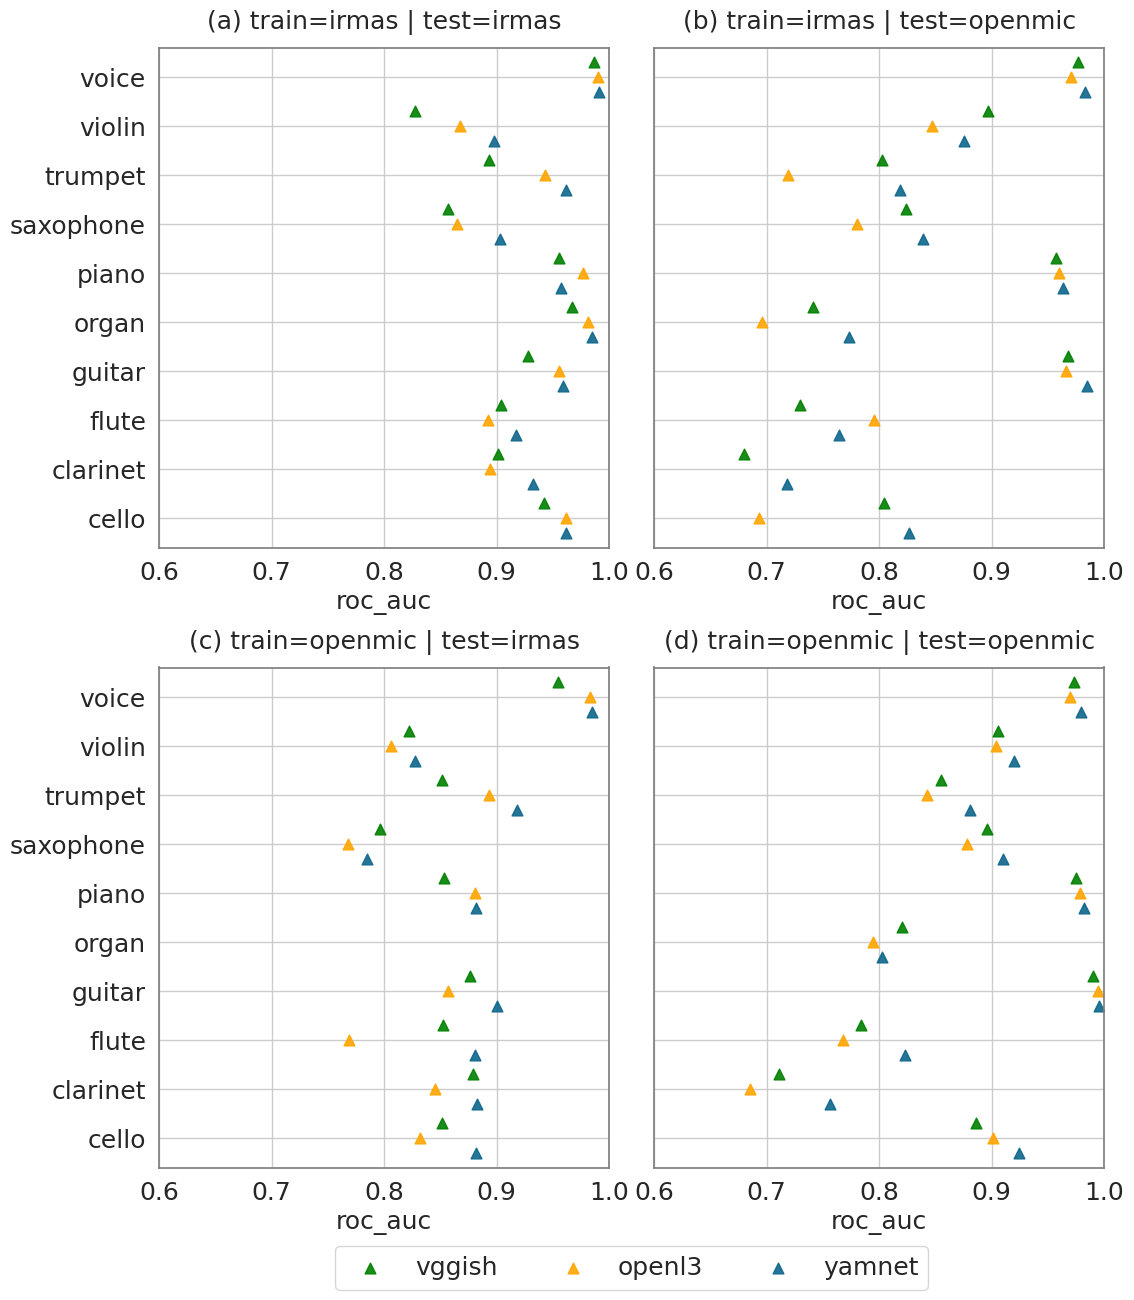

In [11]:
metric = 'roc_auc'
figure = plt.figure(figsize=(9,10))

size = 18
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

   

train_set = 'openmic'; test_set = 'irmas'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])


train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-3,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.27)) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])

train_set = 'irmas'; test_set = 'openmic'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48]); ax.set_yticklabels([]);

plt.tight_layout(); 
plt.savefig('results/original_performance.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")

## statistics

In [7]:
df = pd.read_csv('results/result_linear_all.csv')

In [8]:
df

,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap,embedding
0,cello,irmas,irmas,0.301527,0.840426,0.443820,94.0,0.881152,0.941977,0.604216,vggish
1,clarinet,irmas,irmas,0.297003,0.858268,0.441296,127.0,0.834334,0.901588,0.590706,vggish
2,flute,irmas,irmas,0.331010,0.785124,0.465686,121.0,0.869148,0.903389,0.623614,vggish
3,guitar,irmas,irmas,0.558491,0.855491,0.675799,346.0,0.829532,0.927595,0.814942,vggish
4,organ,irmas,irmas,0.465318,0.925287,0.619231,174.0,0.881152,0.966627,0.759871,vggish
...,...,...,...,...,...,...,...,...,...,...,...
355,piano,openmic,irmas,0.205594,0.864706,0.332203,170.0,0.645258,0.881441,0.659600,yamnet-mlda
356,saxophone,openmic,irmas,0.202811,0.673333,0.311728,150.0,0.732293,0.784472,0.322125,yamnet-mlda
357,trumpet,openmic,irmas,0.287554,0.893333,0.435065,150.0,0.791116,0.918109,0.648311,yamnet-mlda
358,violin,openmic,irmas,0.216216,0.783217,0.338880,143.0,0.737695,0.827778,0.344088,yamnet-mlda


In [9]:
embeddings = ['vggish', 'openl3', 'yamnet', 'vggish-lda', 'openl3-lda', 'yamnet-lda', 'vggish-mlda', 'openl3-mlda', 'yamnet-mlda']

case_mean_all = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])

cases = [['irmas', 'irmas'], ['openmic', 'openmic'], ['openmic', 'irmas'], ['irmas', 'openmic']]
for embedding in embeddings:
    for case in cases:
        train_set = case[0]
        test_set = case[1]
        case_mean = df.loc[(df['train_set'] == train_set) & (df['test_set'] == test_set) 
                        & (df['embedding'] == embedding)]['roc_auc'].values.mean()
        
        case_mean_item = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])
        case_mean_item['embedding'] = [embedding]
        case_mean_item['train_set'] = [train_set]
        case_mean_item['test_set'] = [test_set]
        case_mean_item['mean'] = [case_mean]

        case_mean_all = case_mean_all.append(case_mean_item)
        # print('{}: {} -> {}, mean = {}'.format(embedding, train_set, test_set, case_mean))

In [10]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.915978,NaN
0,vggish,openmic,openmic,0.879543,NaN
0,vggish,openmic,irmas,0.82815,NaN
0,vggish,irmas,openmic,0.838124,NaN
0,openl3,irmas,irmas,0.932664,NaN
0,openl3,openmic,openmic,0.871609,NaN
0,openl3,openmic,irmas,0.805562,NaN
0,openl3,irmas,openmic,0.801629,NaN
0,yamnet,irmas,irmas,0.946498,NaN
0,yamnet,openmic,openmic,0.897392,NaN


In [11]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [12]:
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [13]:
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mlda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mlda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [14]:
case_mean_all = case_mean_all.reset_index(drop=True)

In [15]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.915978,NaN
1,vggish,openmic,openmic,0.879543,NaN
2,vggish,openmic,irmas,0.82815,-0.087827
3,vggish,irmas,openmic,0.838124,-0.041419
4,openl3,irmas,irmas,0.932664,NaN
5,openl3,openmic,openmic,0.871609,NaN
6,openl3,openmic,irmas,0.805562,-0.127102
7,openl3,irmas,openmic,0.801629,-0.06998
8,yamnet,irmas,irmas,0.946498,NaN
9,yamnet,openmic,openmic,0.897392,NaN


In [16]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish, mean: [0.9159775670152692, 0.8795426308397019, 0.8281500968812031, 0.8381238345333191], change: [nan, nan, -0.08782747013406611, -0.04141879630638279]
openl3, mean: [0.9326639180216694, 0.8716086822582018, 0.805561819347328, 0.8016287079403634], change: [nan, nan, -0.1271020986743414, -0.06997997431783831]
yamnet, mean: [0.9464977304079184, 0.897391623351162, 0.8501302963019303, 0.8546504075395533], change: [nan, nan, -0.09636743410598814, -0.04274121581160861]
vggish-lda, mean: [0.9159757843835784, 0.8799284302663853, 0.829947952063834, 0.8381621422404605], change: [nan, nan, 0.0017978551826308697, 3.830770714141618e-05]
openl3-lda, mean: [0.9325578360093407, 0.871621317325699, 0.8056314107923732, 0.8013672239239351], change: [nan, nan, 6.959144504525838e-05, -0.0002614840164283372]
yamnet-lda, mean: [0.9464977304079184, 0.897391623351162, 0.8501307360556682, 0.8546504075395533], change: [nan, nan, 4.3975373797966455e-07, 0.0]
vggish-mlda, mean: [0.9144814500884042, 0.87978946

In [17]:
result_table = []
for embedding in ['vggish', 'openl3', 'yamnet']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])

In [18]:
len(result_table)

9

In [19]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish, mean: [0.9159775670152692, 0.8795426308397019, 0.8281500968812031, 0.8381238345333191], change: [nan, nan, -0.08782747013406611, -0.04141879630638279]
openl3, mean: [0.9326639180216694, 0.8716086822582018, 0.805561819347328, 0.8016287079403634], change: [nan, nan, -0.1271020986743414, -0.06997997431783831]
yamnet, mean: [0.9464977304079184, 0.897391623351162, 0.8501302963019303, 0.8546504075395533], change: [nan, nan, -0.09636743410598814, -0.04274121581160861]
vggish-lda, mean: [0.9159757843835784, 0.8799284302663853, 0.829947952063834, 0.8381621422404605], change: [nan, nan, 0.0017978551826308697, 3.830770714141618e-05]
openl3-lda, mean: [0.9325578360093407, 0.871621317325699, 0.8056314107923732, 0.8013672239239351], change: [nan, nan, 6.959144504525838e-05, -0.0002614840164283372]
yamnet-lda, mean: [0.9464977304079184, 0.897391623351162, 0.8501307360556682, 0.8546504075395533], change: [nan, nan, 4.3975373797966455e-07, 0.0]
vggish-mlda, mean: [0.9144814500884042, 0.87978946

In [20]:
df = pd.DataFrame(columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2'])
embeddings = ['vggish', 'openl3', 'yamnet'] + ['vggish-lda', 'openl3-lda', 'yamnet-lda'] + \
                    ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']
for k in range(len(result_table)):
    new_line = [embeddings[k]] + list(np.round(np.array(result_table[k]) * 100, 2))

    df = df.append(pd.DataFrame([new_line], 
        columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2']), 
        ignore_index=True)
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic,change1,change2
0,vggish,91.6,87.95,82.82,83.81,-8.78,-4.14
1,openl3,93.27,87.16,80.56,80.16,-12.71,-7.0
2,yamnet,94.65,89.74,85.01,85.47,-9.64,-4.27
3,vggish-lda,91.6,87.99,82.99,83.82,0.18,0.0
4,openl3-lda,93.26,87.16,80.56,80.14,0.01,-0.03
5,yamnet-lda,94.65,89.74,85.01,85.47,0.0,0.0
6,vggish-mlda,91.45,87.98,82.7,83.3,-0.11,-0.51
7,openl3-mlda,93.24,87.16,80.67,79.98,0.12,-0.18
8,yamnet-mlda,94.65,89.74,85.01,85.47,-0.0,0.0


In [21]:
df['change1'] = ['(' + str(item) + ')' for item in df['change1']]
df['change2'] = ['(' + str(item) + ')' for item in df['change2']]
df['openmic-irmas'] = [str(df['openmic-irmas'][k]) + ' ' + df['change1'][k] for k in range(len(df['change1']))]
df['irmas-openmic'] = [str(df['irmas-openmic'][k]) + ' ' + df['change2'][k] for k in range(len(df['change2']))]
df = df.drop(columns=['change1', 'change2'])
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic
0,vggish,91.6,87.95,82.82 (-8.78),83.81 (-4.14)
1,openl3,93.27,87.16,80.56 (-12.71),80.16 (-7.0)
2,yamnet,94.65,89.74,85.01 (-9.64),85.47 (-4.27)
3,vggish-lda,91.6,87.99,82.99 (0.18),83.82 (0.0)
4,openl3-lda,93.26,87.16,80.56 (0.01),80.14 (-0.03)
5,yamnet-lda,94.65,89.74,85.01 (0.0),85.47 (0.0)
6,vggish-mlda,91.45,87.98,82.7 (-0.11),83.3 (-0.51)
7,openl3-mlda,93.24,87.16,80.67 (0.12),79.98 (-0.18)
8,yamnet-mlda,94.65,89.74,85.01 (-0.0),85.47 (0.0)


In [22]:
df.to_csv('results/result_table_linear.csv', index=False)

(0.4, 1.0)

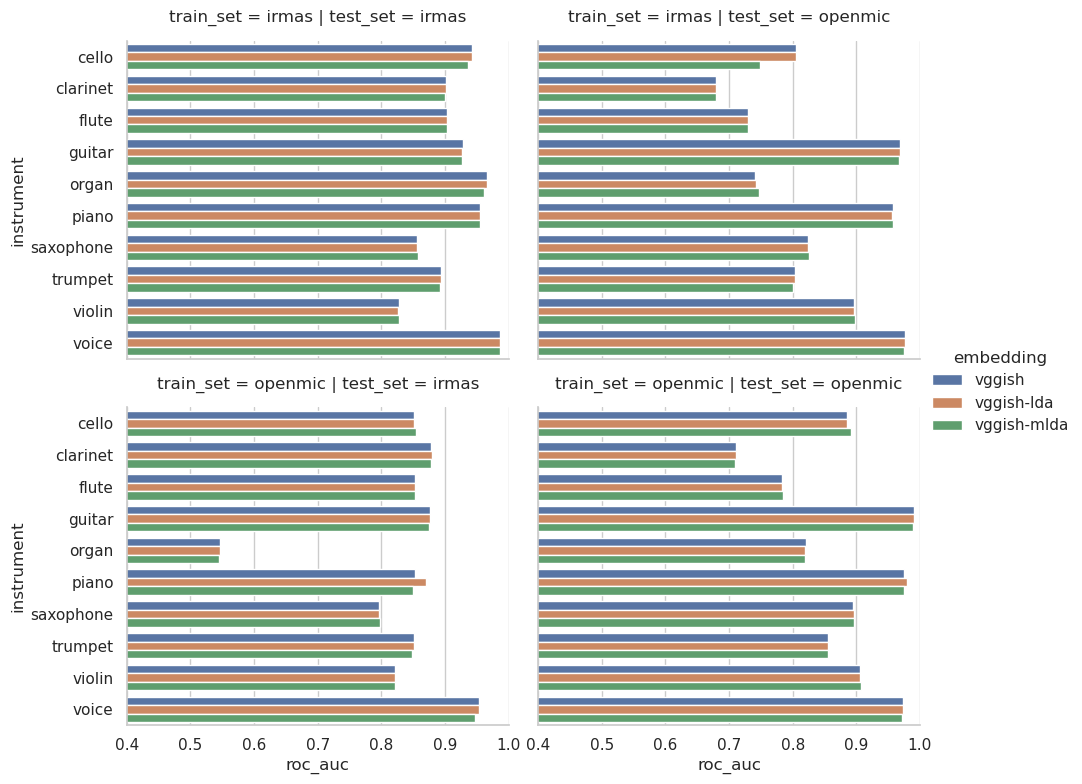

In [23]:
# save all result into a csv file
df = pd.read_csv('results/result_vggish-mlda.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')

(0.4, 1.0)

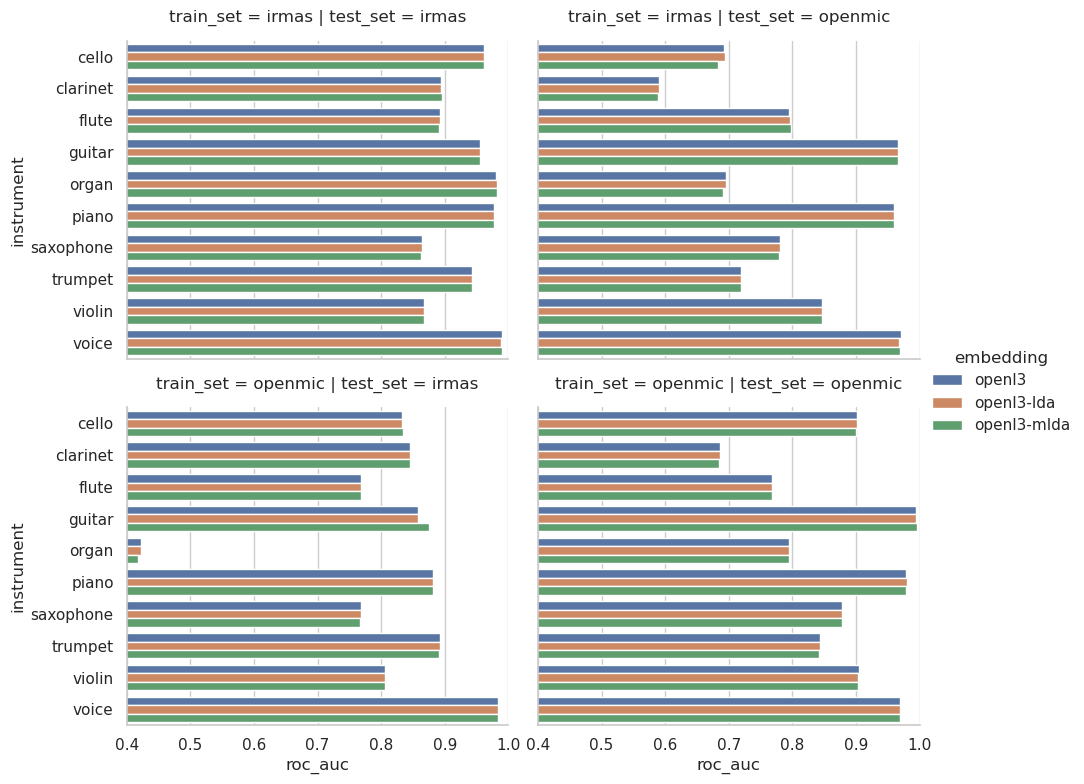

In [24]:
# save all result into a csv file
df = pd.read_csv('results/result_openl3-mlda.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')

(0.4, 1.0)

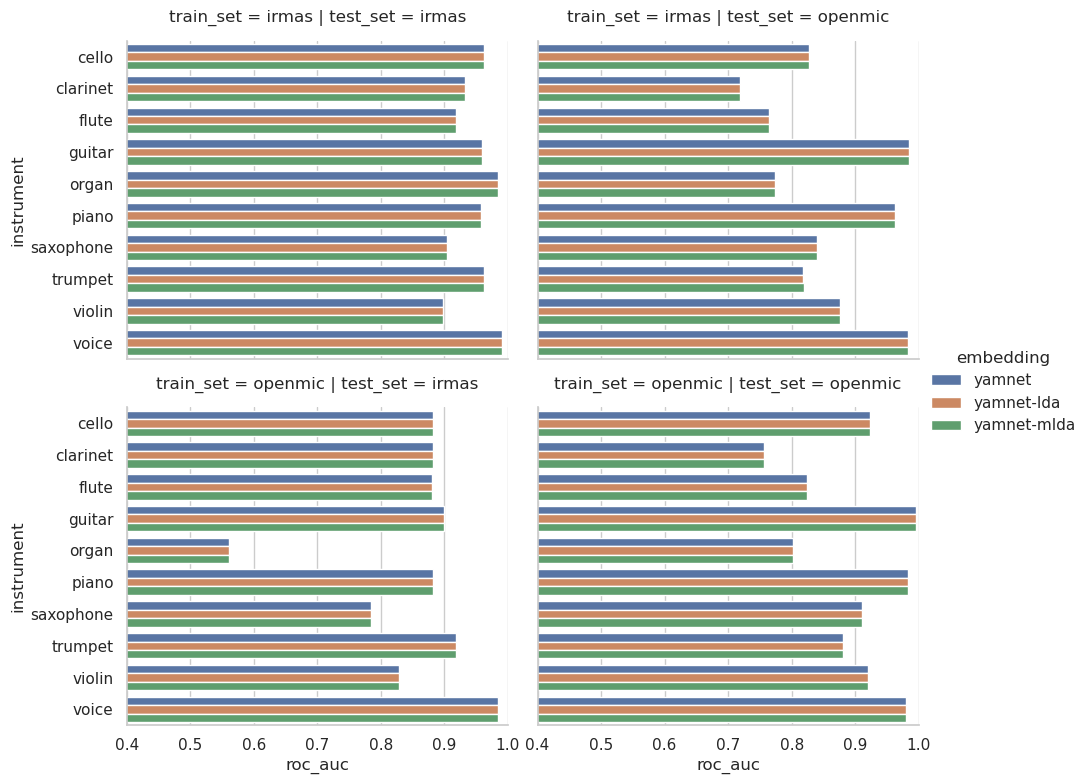

In [25]:
# save all result into a csv file
df = pd.read_csv('results/result_yamnet-mlda.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')